Testing of Landsat-landstats for Kenya

In [1]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
# loading data
df = pd.DataFrame.from_csv('estimates_after_join.csv')
df = df.dropna(axis=0)
df.tail()

,poly,pop,latitude,longitude,area,sublocation_id,sublocation_name,location_id,location_name,estimates
227007,"POLYGON ((39.9112434387207 -3.169800281524658,...",2573.0,39.925623,-3.337241,249.46945,307030602.0,JILORE/ZIANI,3070306.0,JILORE,4.652267
227008,POLYGON ((39.97044372558594 -3.319927930831909...,5083.0,39.943589,-3.337241,14.30654,307030203.0,MIDA,3070302.0,GEDE,4.664816
227011,MULTIPOLYGON (((39.98183473150635 -3.362976867...,8797.0,39.997488,-3.337241,21.11324,307030202.0,DABASO,3070302.0,GEDE,4.493513
227012,POLYGON ((40.09035491943359 -3.309580326080321...,4923.0,40.015454,-3.337241,19.92206,307030302.0,JIMBA,3070303.0,WATAMU,4.481862
227013,POLYGON ((40.09035491943359 -3.309580326080321...,4923.0,40.033421,-3.337241,19.92206,307030302.0,JIMBA,3070303.0,WATAMU,4.482364


In [3]:
# we only need a subset of this data
df_subloc = df[['estimates', 'area', 'location_id', 
                'sublocation_id', 'pop']]
# renaming
df_subloc = df_subloc.rename(
    columns = {'pop': 'pop_sublocation_actual',
              'estimates' : 'density_subloc_est'})

The rows are single 32 x 32 satellite images. 

The convnet predicts the density for each image. This prediction is column 'estimates'.

In [4]:
df_subloc = df_subloc.groupby(['sublocation_id']).mean()
df_subloc.reset_index(level=0, inplace=True)
df_subloc['pop_sublocation_est'] = df_subloc.density_subloc_est * df_subloc.area

In [5]:
df_subloc.tail()

,sublocation_id,density_subloc_est,area,location_id,pop_sublocation_actual,pop_sublocation_est
6046,808040601.0,6.122981,7.86326,8080406.0,4882.0,48.146591
6047,808040603.0,6.032041,4.44766,8080406.0,2566.0,26.828467
6048,808040701.0,5.911922,6.45272,8080407.0,3430.0,38.147980
6049,808040702.0,5.874511,8.44245,8080407.0,3737.0,49.595263
6050,808040703.0,6.148115,4.76776,8080407.0,2192.0,29.312738


Looking at the bottom of the table, it seems like the population estimates are off by an order of 1000. However, it's pretty accurate! Let's look at the top

In [6]:
df_subloc.head()

,sublocation_id,density_subloc_est,area,location_id,pop_sublocation_actual,pop_sublocation_est
0,101010202.0,5.357568,1.39973,1010102.0,10658.0,7.499148
1,101010402.0,5.184173,0.70215,1010104.0,58978.0,3.640067
2,101010502.0,5.441364,1.31049,1010105.0,9701.0,7.130853
3,101020203.0,5.501416,0.36891,1010202.0,6567.0,2.029527
4,101020401.0,5.580007,5.58369,1010204.0,25535.0,31.157028


Our estimates are off by an order of 1000, but it's much less accurate.

The rest of the literature simply takes census data at some level (say Location) and uses weights to distribute across lower levers (e.g. Sublocation). So at the Location level, the population matches the Census. The test is whether the population matches the census at the Sublocation level.


A more ambitious project is simply estimating population at the Sublocation level. Let's get some metrics to do this.

In [7]:
# Root mean square error
df_subloc['error_subloc'] = df_subloc.pop_sublocation_est - df_subloc.pop_sublocation_actual
df_subloc['sq_error_subloc'] = df_subloc.error_subloc**2
rmse = np.sqrt(df_subloc.sq_error_subloc.mean())
print('The root mean squared error is: ', rmse)

# %RMSE: RMSE / mean(population_subloc)
pc_rmse = 100 * rmse / df_subloc.pop_sublocation_actual.mean()
print('The root mean squared percentage error is: ', pc_rmse)

# Mean absolute error
df_subloc['abs_error_subloc'] = abs(df_subloc.pop_sublocation_est - df_subloc.pop_sublocation_actual)
mae = df_subloc.abs_error_subloc.mean()
print('The mean absolute error is: ', mae)

The root mean squared error is:  5938.24157175
The root mean squared percentage error is:  145.429802761
The mean absolute error is:  3963.17498218


Wow! The RMSE and %RMSE are of the same order of magnitude as the literature _with populations matched at the location level as discussed above._ Further, the MAE is an order of magnitude greater. This table is taken from Stevens et al 2015. It's the state of the art. Their work is under rows 'RF'.

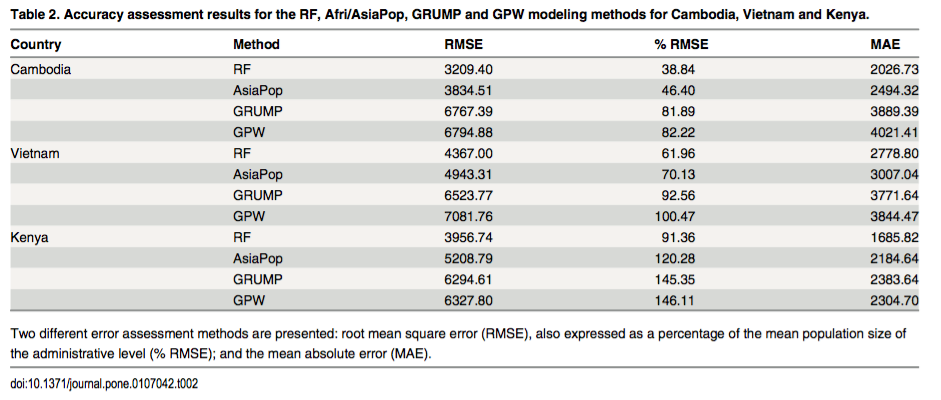

In [8]:
Image(filename='stevens_table_2.png')

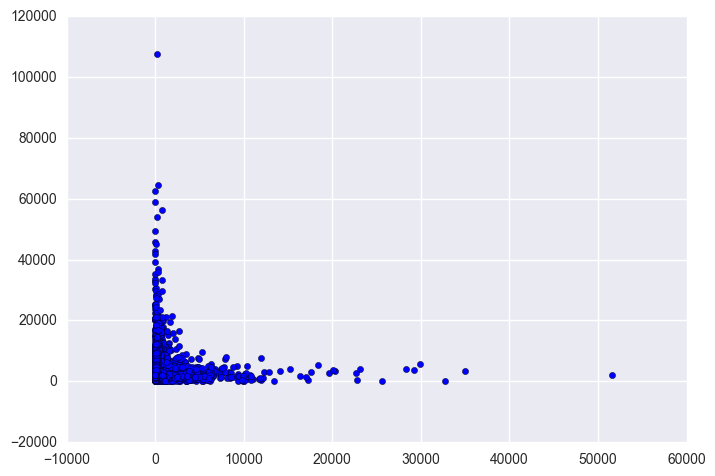

In [9]:
# how about a scatter plot
plt.scatter(df_subloc.pop_sublocation_est, df_subloc.pop_sublocation_actual)

So it looks less good here. That's strangely comforting.

Now, let's use the method the literature does.

In [10]:
# getting location level populations from sublocation data
df_loc = df_subloc[['pop_sublocation_actual', 'pop_sublocation_est', 
                    'location_id']].groupby('location_id').sum()
df_loc.reset_index(level=0, inplace=True)
df_loc = df_loc.rename(columns = {'pop_sublocation_actual': 'pop_location_actual',
                                 'pop_sublocation_est' : 'pop_location_est'})

# merge with sublocation data
df_final = pd.merge(df_subloc, df_loc, on = 'location_id', how = 'left')

# generating weights within a sublocation
df_final['weights']= df_final.pop_sublocation_est / df_final.pop_location_est

# distributing population at the location level by these weights
df_final['pop_sublocation_est_final'] = df_final.weights * df_final.pop_location_actual

In [24]:
# Root mean square error
df_final['error_subloc_final'] = df_final.pop_sublocation_est_final - df_final.pop_sublocation_actual
df_final['sq_error_subloc_final'] = df_final.error_subloc_final**2
rmse_final = np.sqrt(df_final.sq_error_subloc_final.mean())
print('The root mean squared error is: ', rmse_final)

# %RMSE: RMSE / mean(population_subloc)
pc_rmse_final = 100 * rmse_final / df_final.pop_sublocation_actual.mean()
print('The root mean squared percentage error is: ', pc_rmse_final)

# Mean absolute error
df_final['abs_error_subloc_final'] = abs(df_final.pop_sublocation_est_final - df_final.pop_sublocation_actual)
mae_final = df_final.abs_error_subloc_final.mean()
print('The mean absolute error is: ', mae_final)

The root mean squared error is:  2102.35887919
The root mean squared percentage error is:  51.4875714368
The mean absolute error is:  1037.81808375


In [30]:
pc_rmae_final = 100 * mae_final / df_final.pop_sublocation_actual.mean()
print('The root mean squared percentage error is: ', pc_rmae_final)
print('The average population is: ', df_final.pop_sublocation_actual.median())

The root mean squared percentage error is:  25.4165610136
The average population is:  3090.0


In [33]:
mae_final, df_final.pop_sublocation_actual.mean()

(1037.8180837491011, 4083.2356635266897)

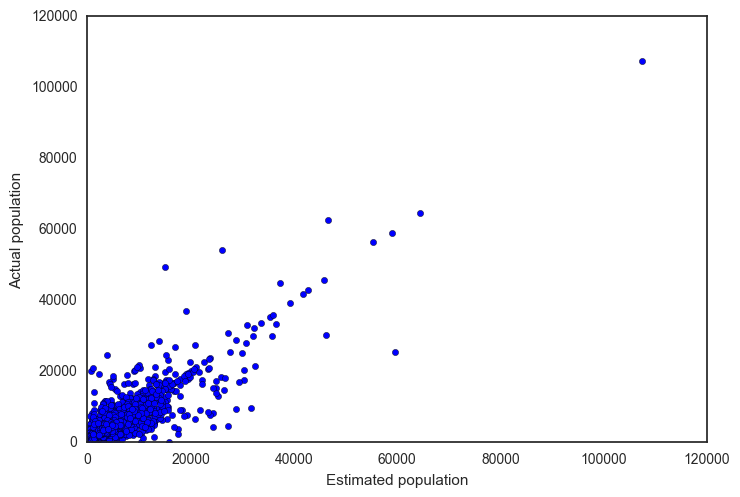

In [12]:
sns.set_style("white")
plt.scatter(df_final.pop_sublocation_est_final, df_final.pop_sublocation_actual)
plt.axis([0, 120000, 0, 120000])
plt.xlabel('Estimated population')
plt.ylabel('Actual population')
plt.savefig('scatter.png', bbox_inches='tight', dpi=300)

Wow. Wow.

** Mapping **

In [13]:
folder = '/Users/patrick/Dropbox/acm_dev/data/shapefiles/ke/sublocations/'
df_geo = gpd.GeoDataFrame.from_file(folder + 'ke_1999.shp')
df_geo = df_geo.rename(columns={'SLID': 'sublocation_id'})

In [14]:
df_geo_sl = pd.merge(df_final, df_geo, on = 'sublocation_id', how = 'inner')
df_geo_sl = gpd.GeoDataFrame(df_geo_sl)
df_geo_sl.tail()

,sublocation_id,density_subloc_est,area,location_id,pop_sublocation_actual,pop_sublocation_est,error_subloc,sq_error_subloc,abs_error_subloc,pop_location_actual,...,PROVID,PROVNAME,SLNAME,SLNAME_y,SUM_FEMALE,SUM_GRTOTA,SUM_HOUSEH,SUM_MALES,SUM_TOTAL,geometry
6048,808040601.0,6.122981,7.86326,8080406.0,4882.0,48.146591,-4833.853409,2.336614e+07,4833.853409,7448.0,...,8.0,WESTERN,EMASATSI,EMASATSI,2631.0,4882.0,1057.0,2251.0,4882.0,"POLYGON ((34.6405029296875 0.16071417927742, 3..."
6049,808040603.0,6.032041,4.44766,8080406.0,2566.0,26.828467,-2539.171533,6.447392e+06,2539.171533,7448.0,...,8.0,WESTERN,MUNJITI,MUNJITI,1419.0,2566.0,566.0,1147.0,2566.0,POLYGON ((34.67526626586914 0.1661078929901123...
6050,808040701.0,5.911922,6.45272,8080407.0,3430.0,38.147980,-3391.852020,1.150466e+07,3391.852020,9359.0,...,8.0,WESTERN,ESHIBINGA,ESHIBINGA,1800.0,3430.0,776.0,1630.0,3430.0,POLYGON ((34.60634994506836 0.1499172300100344...
6051,808040702.0,5.874511,8.44245,8080407.0,3737.0,49.595263,-3687.404737,1.359695e+07,3687.404737,9359.0,...,8.0,WESTERN,EMALINDI,EMALINDI,1958.0,3737.0,801.0,1779.0,3737.0,"POLYGON ((34.6336669921875 0.1549929380416888,..."
6052,808040703.0,6.148115,4.76776,8080407.0,2192.0,29.312738,-2162.687262,4.677216e+06,2162.687262,9359.0,...,8.0,WESTERN,MUNDAHA,MUNDAHA,1151.0,2192.0,494.0,1041.0,2192.0,"POLYGON ((34.64179229736328 0.128506600856781,..."


Plotting maps.

Taken from: http://nbviewer.jupyter.org/gist/jorisvandenbossche/d4e6efedfa1e4e91ab65

In [15]:
import numpy as np
from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)


def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=alpha,
                                          markersize=10, markerfacecolor=cmap.to_rgba(value)))
                ax.legend(patches, categories, numpoints=1, loc='best')
            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

In [16]:
df_geo_sl_prov = df_geo_sl[df_geo_sl.PROVID == 2.0]

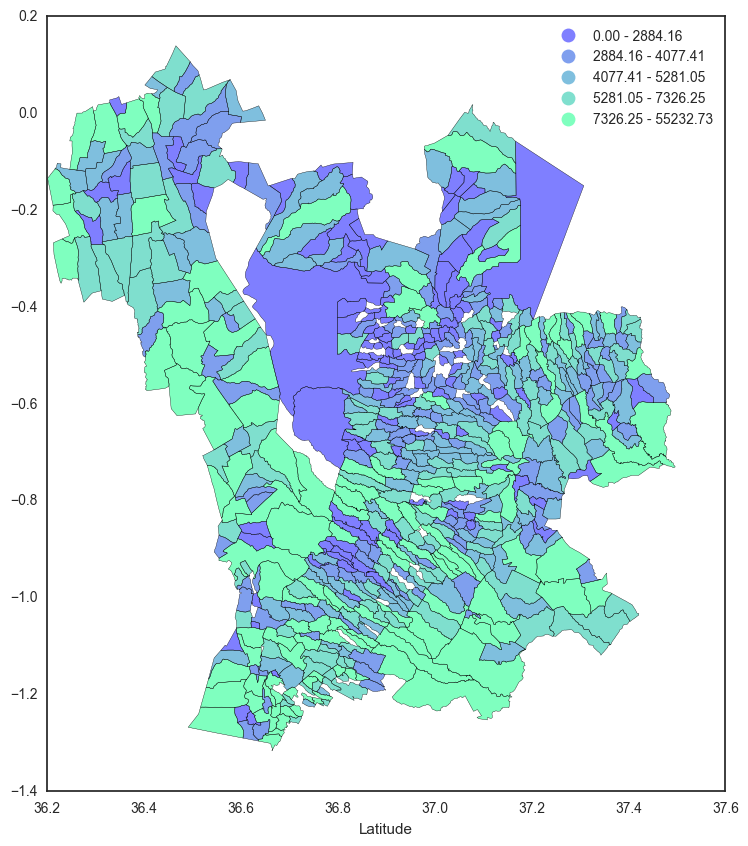

In [19]:
sns.set_style("white")
df_geo_sl_prov.plot(column='pop_sublocation_est_final', linewidth=0.25, figsize=(10, 10), 
                    scheme='Quantiles', k=5, cmap='winter', legend=True)
plt.xlabel('Longitude')
plt.xlabel('Latitude')
plt.savefig('map_est.png', bbox_inches='tight', dpi=300)

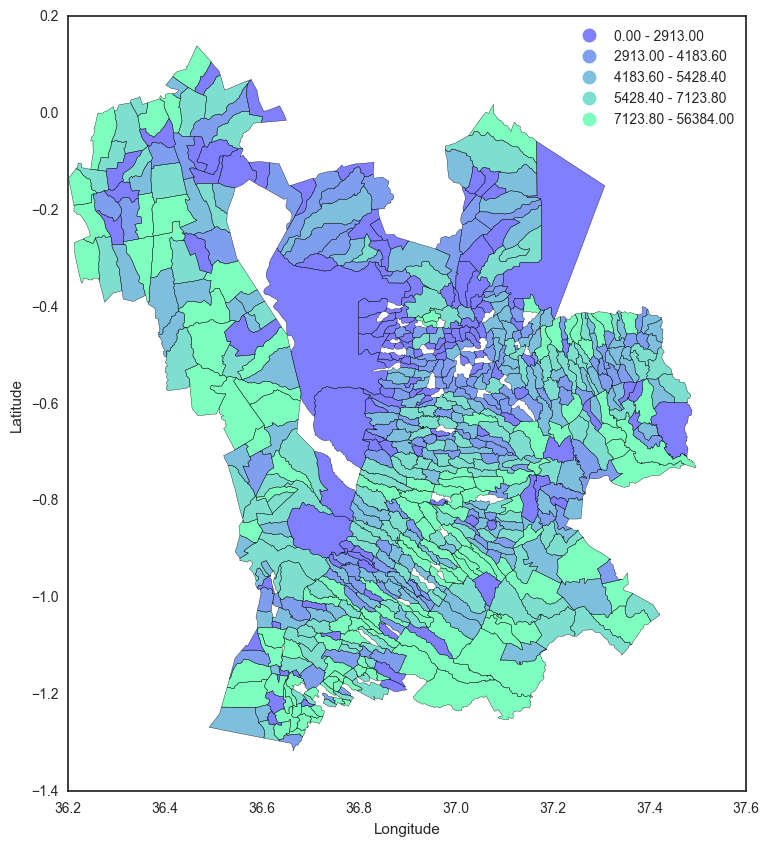

In [21]:
df_geo_sl_prov.plot(column='pop_sublocation_actual', linewidth=0.25, figsize=(10, 10), 
                    scheme='Quantiles', k=5, cmap='winter', legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('map_actual.png', bbox_inches='tight', dpi=300)

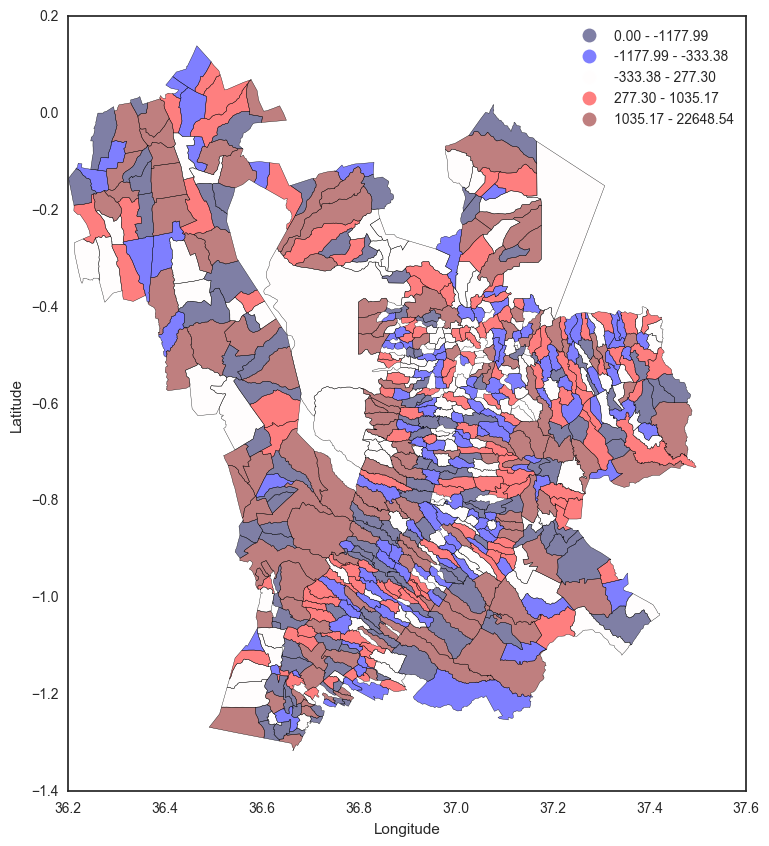

In [23]:
df_geo_sl_prov.plot(column='error_subloc_final', linewidth=0.25, figsize=(10, 10), 
                    scheme='Quantiles', k=5, cmap='seismic', legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('map_error.png', bbox_inches='tight', dpi=300)